<a href="https://colab.research.google.com/github/surendra-yarra/Alpha-AdaptiveHedge-Startegy/blob/main/Alpha_Hedge_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1886800003.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(list(tickers.values()), start=INDICATOR_START_DATE, end=END_DATE)['Close'].ffill().dropna()
[*********************100%***********************]  4 of 4 completed


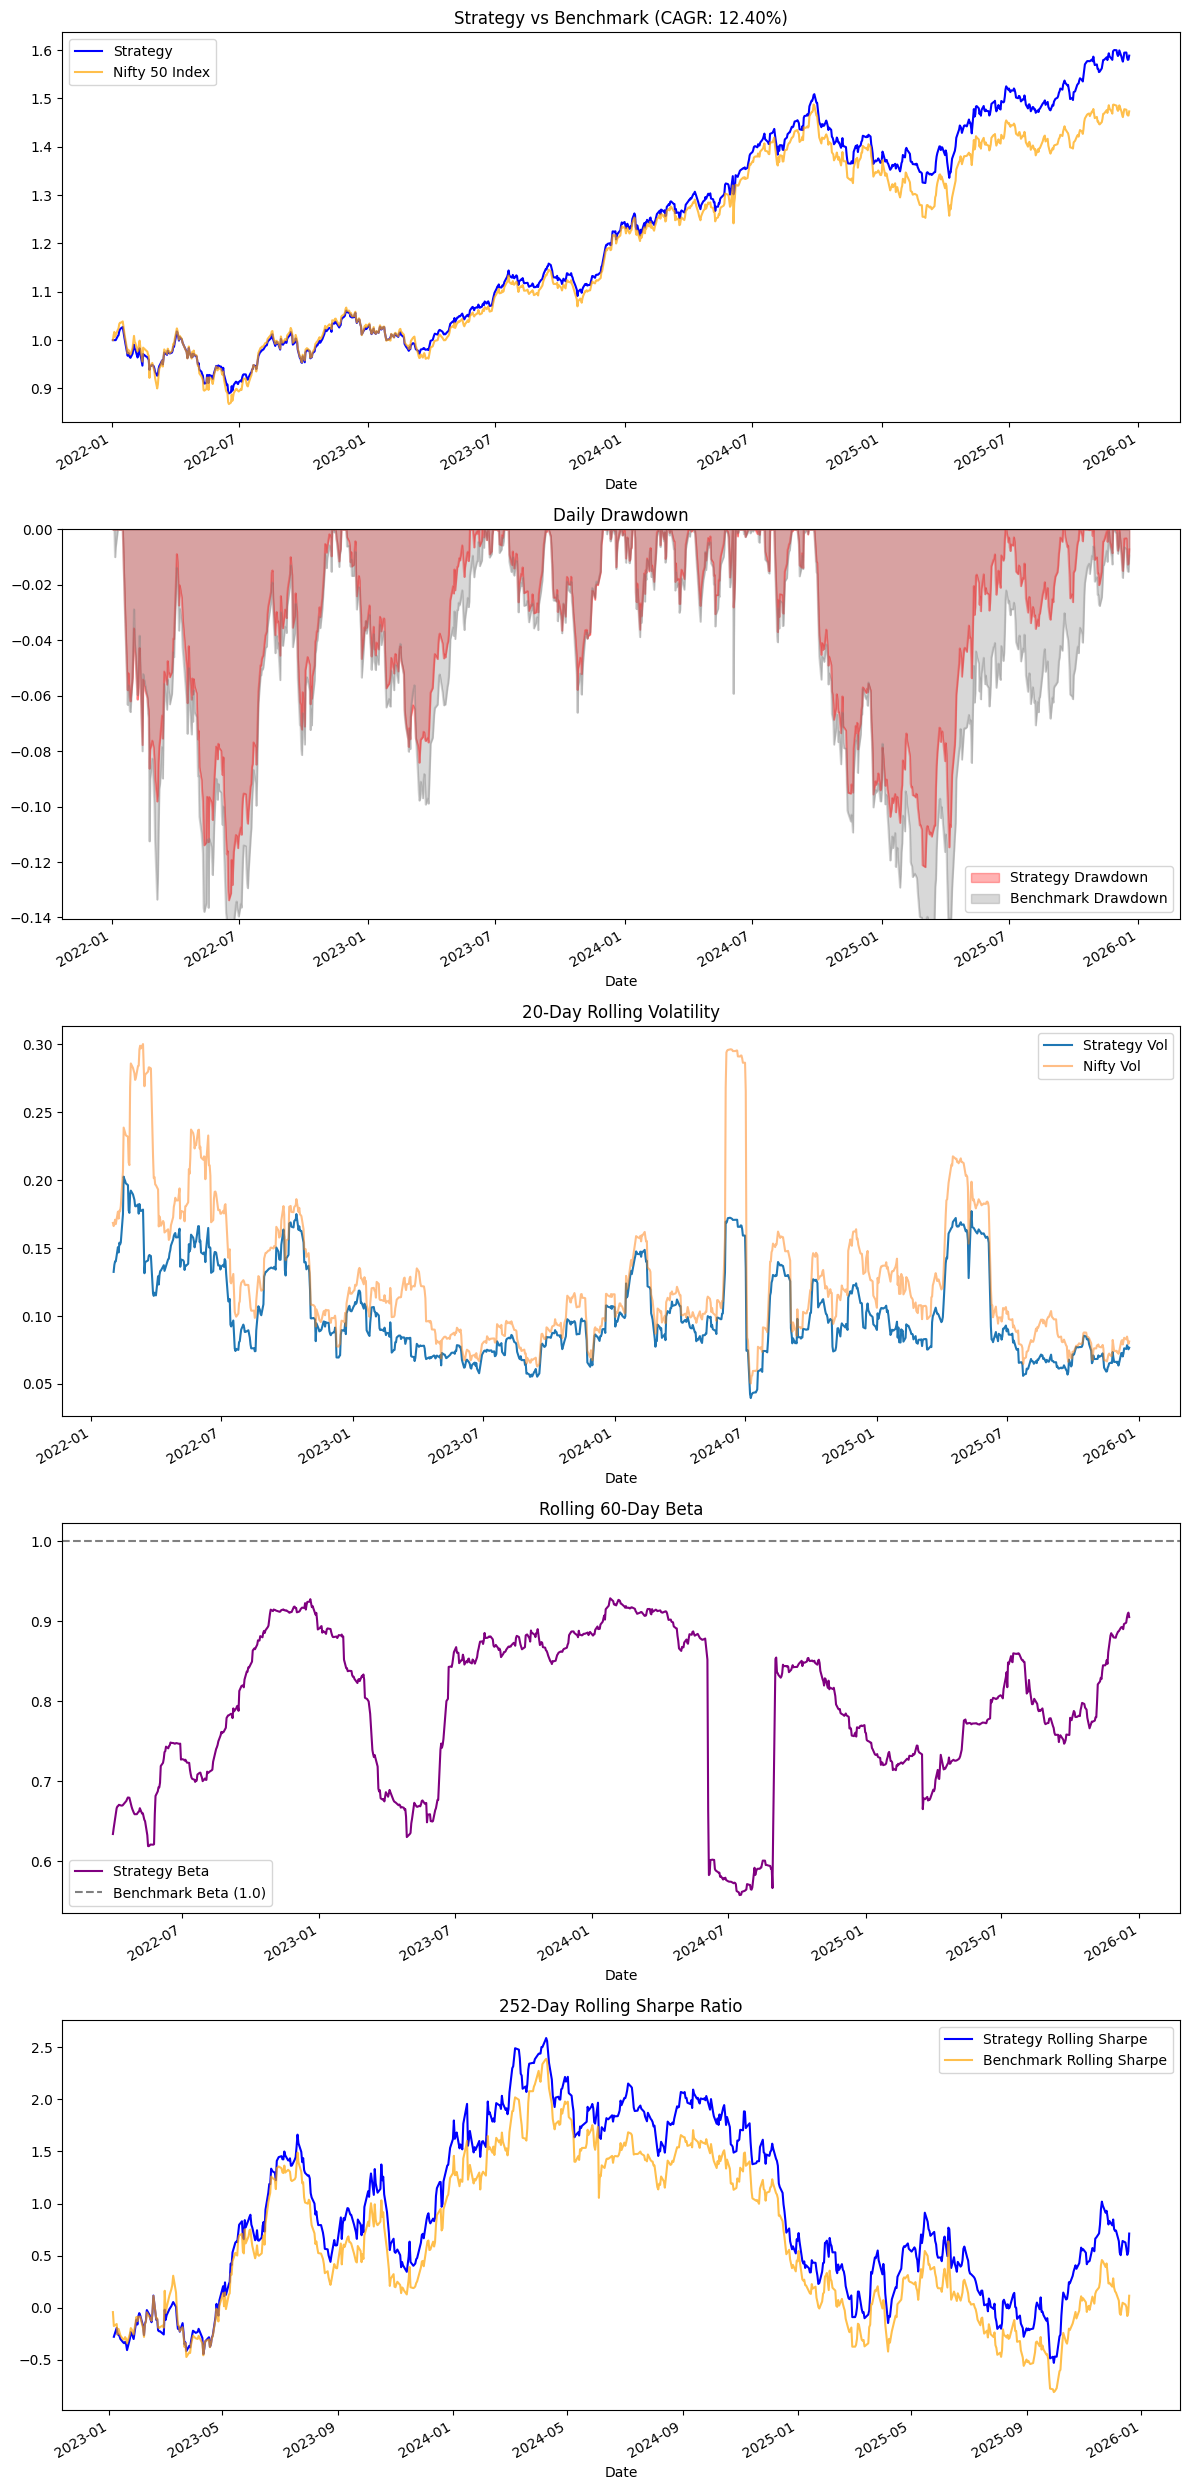

--- Performance Metrics (2022-01-01 to 2025-12-22) ---
Strategy CAGR: 12.40% | Nifty CAGR: 10.28%
Sharpe Ratio: 0.60 | Max Drawdown: -13.38%


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Configuration & Data Fetching
INITIAL_INVESTMENT = 100000
CASH_BUFFER_PCT = 0.002
SLIPPAGE = 0.001  # transaction charge
INDICATOR_START_DATE = '2016-01-01'
START_DATE = '2022-01-01'
END_DATE = '2025-12-22'

tickers = {
    'index': '^NSEI',
    'equity': 'NIFTYBEES.NS',
    'debt': 'LICNETFGSC.NS',
    'gold': 'GOLDBEES.NS'
}

# Fetch data and align dates strictly
all_data = yf.download(list(tickers.values()), start=INDICATOR_START_DATE, end=END_DATE)['Close'].ffill().dropna()
index_data = all_data[tickers['index']]
etf_data = all_data[[tickers['equity'], tickers['debt'], 'GOLDBEES.NS']]

# 2. Signal Generation (Daily)
signals = pd.DataFrame(index_data).rename(columns={tickers['index']: 'price'})
signals['ema50'] = signals['price'].ewm(span=50, adjust=False).mean()
signals['ema100'] = signals['price'].ewm(span=100, adjust=False).mean()
signals['ema200'] = signals['price'].ewm(span=200, adjust=False).mean()
signals['below_all'] = (signals['price'] < signals['ema50']) & (signals['price'] < signals['ema100']) & (signals['price'] < signals['ema200'])
signals['above_50'] = (signals['price'] > signals['ema50'])

def get_target_alloc(date, row, history):
    p, e50, e100, e200 = row['price'], row['ema50'], row['ema100'], row['ema200']
    current_above_50 = row['above_50'] # Current day's 'above_50' status
    hist_week = history.resample('W-FRI').last()

    # 2-week Above 50 EMA logic
    cons_above_2 = hist_week['above_50'].iloc[-2:].all() if len(hist_week) >= 2 else False
    # Rule 1: Sustained uptrend → max risk-on
    if cons_above_2:
        return (0.95, 0.00, 0.05)

    # Rule 2: Price stretched >5% above 50 EMA (no weekly condition)
    if p > e50 and p > (e50 * 1.05):
        return (0.90, 0.05, 0.05)

    # NEW LOGIC: If not 2-week above 50 EMA, but current price is above 50 EMA,
    # and none of the explicit rules above were met, then return None.
    # This prevents rebalancing when the condition is not strong enough for a defined allocation
    # but also not a bearish signal.
    if not cons_above_2 and current_above_50:
        return None

    # 3-week Below All logic
    cons_below_3 = hist_week['below_all'].iloc[-3:].all() if len(hist_week) >= 3 else False
    if cons_below_3:
        return (0.80, 0.10, 0.10)

    # Scenarios with Gold/Debt Tilt (these implicitly handle cases where current_above_50 is False, i.e., p < e50 is True)
    if p < e50 and p < e100 and p < e200:
        return (0.65, 0.15, 0.20)
    if p < e50 and p < e100:
        return (0.75, 0.10, 0.15)

    # The original default allocation is now returned if:
    # 1. None of the above explicit `if` conditions are met.
    # 2. This implies `current_above_50` was `False` (otherwise `return None` would have triggered).
    # 3. This also means specific `p < e50` rules (like `p < e50 and p < e100`) were not met.
    # In essence, this is the fallback for `p < e50` scenarios that aren't severe enough for other defined allocations.
    return (0.95, 0.00, 0.05)


# 3. Iterative Backtest Engine
cash = 0 # Initialize to 0, to be set at START_DATE
holdings = {t: 0 for t in tickers.values() if t != tickers['index']} # Initialize holdings to empty
portfolio_log = []
transaction_log = []
last_alloc = None
strategy_started = False # New flag to control when the strategy officially starts

for date, row in signals.iterrows():
    if not strategy_started and date >= pd.to_datetime(START_DATE):
        # Initialize strategy at START_DATE
        cash = INITIAL_INVESTMENT
        holdings = {t: 0 for t in tickers.values() if t != tickers['index']} # Ensure holdings are also empty at START_DATE
        strategy_started = True
        # First rebalance if START_DATE is a rebalance day, otherwise just hold cash

    if not strategy_started:
        # If strategy hasn't started yet, just continue to build signals history
        continue

    is_rebalance_day = (date.weekday() == 4)
    current_prices = etf_data.loc[date]
    holding_value = sum(holdings[t] * current_prices[t] for t in holdings)
    total_value = holding_value + cash

    rebal_triggered = "No"
    if is_rebalance_day:
        target_weights = get_target_alloc(date, row, signals.loc[:date])

        # MODIFIED: Handle None return from get_target_alloc
        if target_weights is None:
            # If target_weights is None, skip rebalancing for this day, keep last_alloc unchanged
            rebal_triggered = "Skipped (None)"
        elif target_weights != last_alloc:
            usable_val = total_value * (1 - CASH_BUFFER_PCT)

            # SELLS first
            for i, t in enumerate([tickers['equity'], tickers['debt'], tickers['gold']]):
                target_val = usable_val * target_weights[i]
                current_val = holdings[t] * current_prices[t]
                if current_val > target_val:
                    shares_to_sell = np.ceil((current_val - target_val) / current_prices[t])
                    sell_price = current_prices[t] * (1 - SLIPPAGE)
                    cash += (shares_to_sell * sell_price)
                    holdings[t] -= shares_to_sell
                    transaction_log.append({'Date': date, 'Security': t, 'Type': 'SELL', 'Price': sell_price, 'Shares': shares_to_sell})

            # BUYS second
            for i, t in enumerate([tickers['equity'], tickers['debt'], 'GOLDBEES.NS']):
                target_val = usable_val * target_weights[i]
                current_val = holdings[t] * current_prices[t]
                if target_val > current_val:
                    buy_price = current_prices[t] * (1 + SLIPPAGE)
                    shares_to_buy = np.floor((target_val - current_val) / buy_price)
                    if cash >= (shares_to_buy * buy_price):
                        cash -= (shares_to_buy * buy_price)
                        holdings[t] += shares_to_buy
                        transaction_log.append({'Date': date, 'Security': t, 'Type': 'BUY', 'Price': buy_price, 'Shares': shares_to_buy})

            last_alloc = target_weights
            rebal_triggered = "Yes"

    portfolio_log.append({
        'Date': date, 'Holding_Value': holding_value, 'Cash': cash, 'Portfolio_Value': total_value,
        'Equity_W': (holdings[tickers['equity']]*current_prices[tickers['equity']])/total_value if total_value > 0 else 0,
        'Debt_W': (holdings[tickers['debt']]*current_prices[tickers['debt']])/total_value if total_value > 0 else 0,
        'Gold_W': (holdings[tickers['gold']]*current_prices[tickers['gold']])/total_value if total_value > 0 else 0,
        'Rebalance': rebal_triggered, 'Absolute_Returns': (total_value/INITIAL_INVESTMENT)-1
    })

# 4. Analytics Calculation
port_df = pd.DataFrame(portfolio_log).set_index('Date')
port_df['Daily_Ret'] = port_df['Portfolio_Value'].pct_change()
bench_rets = index_data.pct_change()

# Beta (calculated on full data, but we will plot filtered)
cov = port_df['Daily_Ret'].rolling(60).cov(bench_rets)
var = bench_rets.rolling(60).var()
port_df['Beta'] = cov / var

# Filter data for calculations and plotting from START_DATE
filtered_port_df = port_df.loc[START_DATE:]
filtered_index_data = index_data.loc[START_DATE:]

# Re-calculate overall performance metrics for the period START_DATE to END_DATE
years = (filtered_port_df.index[-1] - filtered_port_df.index[0]).days / 365.25
cagr = (filtered_port_df['Portfolio_Value'].iloc[-1] / filtered_port_df['Portfolio_Value'].iloc[0]) ** (1/years) - 1
bench_cagr = (filtered_index_data.iloc[-1] / filtered_index_data.iloc[0]) ** (1/years) - 1

# Sharpe & Vol
std_dev = filtered_port_df['Daily_Ret'].std() * np.sqrt(252)
sharpe = (cagr - 0.06) / std_dev # Assuming 6% Risk Free Rate

# Max Drawdown from the filtered data
dd_strategy = filtered_port_df['Portfolio_Value'] / filtered_port_df['Portfolio_Value'].cummax() - 1
max_dd = dd_strategy.min()

# 5. Output Files

with pd.ExcelWriter('Alpha_Hedge_Strategy_Report.xlsx') as writer:
    # Only write transactions that happened on or after START_DATE
    pd.DataFrame([t for t in transaction_log if t['Date'] >= pd.to_datetime(START_DATE)]).to_excel(writer, sheet_name='Transactions')
    # Use filtered_port_df and filtered_signals for sheets to reflect START_DATE
    filtered_port_df[['Equity_W', 'Debt_W', 'Gold_W']].to_excel(writer, sheet_name='Daily_Allocation')
    filtered_port_df[['Holding_Value', 'Cash', 'Portfolio_Value', 'Rebalance', 'Absolute_Returns', 'Beta']].to_excel(writer, sheet_name='Daily_Portfolio')
    signals.loc[START_DATE:][['price', 'ema50', 'ema100', 'ema200']].to_excel(writer, sheet_name='Index_EMAs')

# 6. Plotting
fig, ax = plt.subplots(5, 1, figsize=(12, 25)) # Increased subplot count and figure size

# Normalize returns from the START_DATE
initial_port_value = filtered_port_df['Portfolio_Value'].iloc[0]
initial_index_value = filtered_index_data.iloc[0]

# Normalized Returns (ax[0])
(filtered_port_df['Portfolio_Value']/initial_port_value).plot(ax=ax[0], label='Strategy', color='blue')
(filtered_index_data/initial_index_value).plot(ax=ax[0], label='Nifty 50 Index', color='orange', alpha=0.7)
ax[0].set_title(f'Strategy vs Benchmark (CAGR: {cagr*100:.2f}%)')
ax[0].legend()

# Drawdown (ax[1])
bench_cum_returns = (1 + filtered_index_data.pct_change()).cumprod().fillna(1)
bench_dd = bench_cum_returns / bench_cum_returns.cummax() - 1

dd_strategy.plot(ax=ax[1], kind='area', color='red', alpha=0.3, label='Strategy Drawdown')
bench_dd.plot(ax=ax[1], kind='area', color='grey', alpha=0.3, label='Benchmark Drawdown')
ax[1].set_title('Daily Drawdown')
ax[1].legend()

# Volatility (ax[2])
filtered_port_df['Daily_Ret'].rolling(20).std().apply(lambda x: x*np.sqrt(252)).plot(ax=ax[2], label='Strategy Vol')
bench_rets.loc[START_DATE:].rolling(20).std().apply(lambda x: x*np.sqrt(252)).plot(ax=ax[2], label='Nifty Vol', alpha=0.5)
ax[2].set_title('20-Day Rolling Volatility')
ax[2].legend()

# Beta (ax[3])
filtered_port_df['Beta'].plot(ax=ax[3], title='Rolling 60-Day Beta', color='purple', label='Strategy Beta')
ax[3].axhline(1.0, color='gray', linestyle='--', label='Benchmark Beta (1.0)') # Add line for benchmark beta
ax[3].legend()

# Sharpe Ratio (ax[4]) - NEW SUBPLOT
rf_rate_annual = 0.06
rf_rate_daily = (1 + rf_rate_annual)**(1/252) - 1

rolling_window = 252 # For annualizing

# Strategy Rolling Sharpe
strategy_rolling_returns = filtered_port_df['Daily_Ret']
strategy_rolling_std = strategy_rolling_returns.rolling(rolling_window).std()
strategy_rolling_mean = strategy_rolling_returns.rolling(rolling_window).mean()
rolling_sharpe_strategy = (strategy_rolling_mean - rf_rate_daily) / strategy_rolling_std * np.sqrt(rolling_window)
rolling_sharpe_strategy.plot(ax=ax[4], label='Strategy Rolling Sharpe', color='blue')

# Benchmark Rolling Sharpe
benchmark_rolling_returns = bench_rets.loc[START_DATE:]
benchmark_rolling_std = benchmark_rolling_returns.rolling(rolling_window).std()
benchmark_rolling_mean = benchmark_rolling_returns.rolling(rolling_window).mean()
rolling_sharpe_benchmark = (benchmark_rolling_mean - rf_rate_daily) / benchmark_rolling_std * np.sqrt(rolling_window)
rolling_sharpe_benchmark.plot(ax=ax[4], label='Benchmark Rolling Sharpe', color='orange', alpha=0.7)

ax[4].set_title(f'{rolling_window}-Day Rolling Sharpe Ratio')
ax[4].legend()

plt.tight_layout()
plt.show()

print(f"--- Performance Metrics ({START_DATE} to {END_DATE}) ---")
print(f"Strategy CAGR: {cagr*100:.2f}% | Nifty CAGR: {bench_cagr*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f} | Max Drawdown: {max_dd*100:.2f}%")